I recently thought up a machine learning algorithm called <a href=http:asymptoticlabs.com/blog/posts/smooth-kernel-machines.html>"Smooth Kernel Macines" (SKM)</a>.  In this post I will try out SKM on the ever ubiquitous MNIST dataset. The goal of this post is not so much to achieve state of the art performance on MNIST (though that would be nice), as it is to simply try out SKM on a familiar and well understood dataset.  


tldr; I achieve a respectable 0.006 error rate using an SKM type layer on top of a convolutional neural net feature extractor. An SKM output layer works a little better than a K way softmax (at least for MNIST). SKM trains faster, and comes with an accurate built in measure of prediction confidence.  

<!-- TEASER_END -->

In [1]:
import numpy as np
np.random.seed(1234)

import pandas as pd
import scipy.spatial
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
import sklearn.mixture
from sklearn.neighbors import NearestNeighbors
import sklearn.decomposition

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda
from tensorflow.keras.layers import BatchNormalization, Flatten, Dropout

In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":14,
        "image.cmap":"viridis",
        "image.aspect":"auto",
        "lines.linewidth":2,
    }
)

## Data Loading and Preprocessing

We need to load up the data, convert the digits to a one-hot type binary encoding so that averages of the label vectors make sense and then normalize the digit images to have unit norm and zero mean.  

In [3]:
#load the data
from tensorflow.keras.datasets import mnist as dset
(x_train, y_train), (x_test, y_test) = dset.load_data()

n_categories = len(np.unique(y_train))
y_train_onehot = keras.utils.to_categorical(y_train, n_categories)
y_test_onehot =  keras.utils.to_categorical(y_test, n_categories)

In [4]:
def normalize_images(
    im_arr,
):
    im_arr = im_arr.astype(float)
    flat_ims = im_arr.reshape((-1, np.prod(im_arr.shape[1:])))
    means = np.mean(flat_ims, axis=1)
    norms = np.std(flat_ims, axis=1)
    broadcast_shape = [-1] + (len(im_arr.shape)-1)*[1]
    return (im_arr-means.reshape(broadcast_shape))/norms.reshape(broadcast_shape)

In [5]:
#convert training data to floats and normalize
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

# Feature Extractor

To extract the features for the SKM model I have decided to use a three sets of of 3x3 convolution layers feeding into 1x1 <a href=https://arxiv.org/abs/1602.07360>Squeeze Layers</a> feeding in to max pooling layers with stride 2. I have left out the max pooling layer on the final set of 3x3 and 1x1 convolutions letting the dense output layers do the remaining dimensionality reduction. I have opted for exponential linear units (ELU) instead of the more often employed rectified linear units (ReLU) out of an intuition that the sharp edges of the ReLU will cause more spurious similarities since the distance between any 2 points on the saturated part of the ReLU will be 0 but the distances go smoothly towards 0 in the case of the ELU. However the hand full of numerical experiments I have done seem to suggest that although the ELU may in fact perform slightly better there is not a great deal of difference in performance at least for this dataset.

In order to be able to exactly clone the weights from the SKM network into a regular softmax output network for comparison purposes I have opted for a 10 dimensional similarity space. This turns out to be slightly more dimensions than is necessary for the similarity embedding (see the PCA analysis below) but the hand full of extra dimensions don't seem to adversely affect model performance.

In [6]:
def make_feature_extractor(
    n_squeezed,
    squeeze_ratio,
    inner_activation,
    output_dimension,
    output_activation,
    im_size,
):
    x_in = keras.layers.Input(im_size)
    
    x = x_in
    if len(im_size) == 2:
        #expand dimensions to be length x width x channels 
        x = Lambda(lambda x: tf.expand_dims(x, axis=3))(x)
    
    n_large = int(squeeze_ratio*n_squeezed)
    x = Conv2D(n_large, (3, 3), padding="same", activation=inner_activation)(x)
    x = Conv2D(n_squeezed, (1, 1), padding="same", activation=inner_activation)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
    
    x = Conv2D(n_large, (3, 3), padding="same", activation=inner_activation)(x)
    x = Conv2D(n_squeezed, (1, 1), padding="same", activation=inner_activation)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
    
    x = Conv2D(n_large, (3, 3), padding="valid", activation=inner_activation)(x)
    x = Conv2D(n_squeezed, (1, 1), padding="valid", activation=inner_activation)(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.15)(x)
    
    x = Dense(128, activation=inner_activation)(x)
    x = Dense(output_dimension, activation=output_activation)(x)
    
    return keras.models.Model(x_in, x)

In [7]:
im_size = x_train.shape[1:]

shared_net_kwargs = dict(
    n_squeezed=32,
    squeeze_ratio=4,
    output_dimension=10,
    inner_activation="elu",
    im_size=im_size,
)

#feature extractor network to generate similarity space for use in SKM
feature_nn = make_feature_extractor(
    output_activation=None,
    **shared_net_kwargs,
)

#regular softmax classifier with same architecture
softmax_model = make_feature_extractor(
    output_activation="softmax",
    **shared_net_kwargs,
)
softmax_model.compile(loss="categorical_crossentropy", optimizer="adam")

In order to be sure that the difference in performance of the softmax network and the performance of the SKM network is not just due to a lucky (or unlucky) set of starting weights we clone the starting weights of one network into the other so that we can meaningfully compare their initial performance and training curves.

In [8]:
#clone the starting parameters of one network into the other
starting_weights = feature_nn.get_weights()
softmax_model.set_weights(starting_weights)

In [9]:
feature_nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4128  

At just around 200,000 total parameters the model is pretty light weight. Many fewer parameters than is typically used for example at the time of this writing the current <a href=https://www.tensorflow.org/tutorials/layers> TensorFlow MNIST tutorial </a> architecture uses over 3 million parameters and achieves a test accuracy of 97.3% after 33 training epochs. This seems like an intentionally weak choice of network architecture (maybe to allow people the thrill of improving the networks performance by making tweaks?) By contrast using a 3x3 instead of 5x5 kernel size and a smaller intermediate dense layers and slightly heavier dropout regularization the <a href=https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py> keras MNIST example </a> uses just around 2 million parameters and hits 99.25% test set accuracy.

It is difficult to count up parameters in papers in the literature but as best as I can tell looking at the papers with close to state of the art performance <a href=http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e> found here </a> I think parameter counts of a couple million is typical. By fiddling with the architecture I have managed to get as high as 99.2 test accuracy using only 70,000 parameters but at the end of the day performance matters more than network size, a net that has a 50% lower error rate at the cost of 100% more computation is almost always going to be worth the extra overhead. This lightweight 200,000 parameter network works almost as well as any larger network I tried out and so we will stick with it.

# Kernel Function

In the first SKM post we used a Gaussian kernel similarity function and there was no need to fiddle with the width parameter of the Gaussian. However in the 10 dimensional similarity space that we are using in this post the ability of the model to productively train becomes very sensitive to the choice of kernel width parameter of a Gaussian kernel. If the kernel is too narrow then all points are effectively isolated which leads to either extremely inefficient learning or complete model divergence (usually the latter). If the similarity kernel is too wide then the similarity of the closest points are all essentially the same. The points which most strongly drive the gradient are those at distances which are very near to the kernel width $\sigma$ points much closer than that and points much farther away both having little to no effect. This leads to non-intuitive effects and very inefficient model training or outright model divergence (usually the former).  

Ideally we would like to avoid the need to carefully tune the kernel width of our models as a hyper parameter. To avoid the first trouble of an overly narrow kernel leading to isolated points with effectively 0 similarity to each other we just need to make the kernel fall off a little more slowly. To handle the second problem of indifference of the gradient to points near r=0 we simply need to pick a similarity kernel such that not only does the value of the similarity fall off to 0 with increasing distance but so does the first derivative.

The first function which comes to mind as an alternative to the Gaussian kernel is the exponential kernel. The tails of the exponential kernel fall off much more slowly than the Gaussian meaning that we have to worry less about making the similarity kernel too narrow. The derivative of the exponential similarity with respect to distance is proportional to the similarity itself, thus the training gradient is coupled to pairs of points directly in proportion to the degree of similarity between those points which seems ideal. In fact in this experiment the choice of exponential kernel seems to serve us well. 

There is a slight complication due to the fact that the limited numerical precision the pairwise squared distance that comes out of the tf_pairwise_sq_distance_matrix function is sometimes very slightly negative. To solve this we have added a small positive constant to all squared distances prior to taking the square root to ensure positivity.

Unfortunately the use of the exponential kernel instead of the Gaussian kernel doesn't completely eliminate the need for tuning the kernel width as a hyper parameter but the few experiments I have carried out show it to be much more forgiving than the Gaussian kernel.

In [10]:
def tf_pairwise_sq_distance_matrix(x1, x2):
    r1 = tf.reduce_sum(x1*x1, 1)
    r2 = tf.reduce_sum(x2*x2, 1)
    r1 = tf.reshape(r1, [-1, 1])
    r2 = tf.reshape(r2, [-1, 1])
    D = r1 - 2*tf.matmul(x1, tf.transpose(x2)) + tf.transpose(r2)
    return D

def make_similarity_matrix(
    prototype_embedding,
    target_embedding,
    kernel,
):
    x1 = prototype_embedding
    if target_embedding == None:
        x2 = x1
    else:
        x2 = target_embedding
    
    sq_dists = tf_pairwise_sq_distance_matrix(x2, x1)
    sim_mat = kernel(sq_dists)
    
    return sim_mat

def make_similarity_weighted_average(
    similarity_matrix,
    prototype_labels,
    exclude_diagonal,
    k0,
    central_value,
    sm_eps,
):
    numerator = (central_value*sm_eps + tf.einsum("ij,jk->ik", similarity_matrix, prototype_labels))
    denominator = tf.expand_dims((sm_eps + tf.reduce_sum(similarity_matrix, axis=1)), axis=1)
    
    if exclude_diagonal:
        numerator = numerator - k0*prototype_labels
        denominator = denominator - k0
    
    pred = numerator/denominator
    
    return pred

In [11]:
kernel_gamma = 0.5
kernel_sm = 0.01
sim_kernel_tf = lambda x: tf.exp(-kernel_gamma*tf.sqrt(kernel_sm  + x))
sim_kernel_np = lambda x: np.exp(-kernel_gamma*np.sqrt(kernel_sm + x))

x_proto = keras.layers.Input(im_size)
x_in =  keras.layers.Input(im_size)

feats_proto = feature_nn(x_proto)
feats_in = feature_nn(x_in)

sim_func = lambda x: make_similarity_matrix(
    prototype_embedding=x[0],
    target_embedding=x[1], 
    kernel=sim_kernel_tf,
)

y_proto = keras.layers.Input((n_categories,))

sim_matrix = keras.layers.Lambda(sim_func)(
    [feats_proto, feats_in]
)

prob_func = lambda x: make_similarity_weighted_average(
    similarity_matrix=x[0],
    prototype_labels=x[1],
    exclude_diagonal=False,
    k0=sim_kernel_np(0.0),
    central_value=0.005,
    sm_eps=0.001,
)
probs = keras.layers.Lambda(prob_func)([sim_matrix, y_proto,])

skm_model = keras.models.Model([x_proto, y_proto, x_in], probs)
skm_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam"
)

#pseudocount model for evaluating prediction confidence
pseudocounts = keras.layers.Lambda(
    lambda x: tf.einsum("ij,jk->ik", x[0], x[1])
)([sim_matrix, y_proto])
skm_pseudocount_model = keras.models.Model([x_proto, y_proto, x_in], pseudocounts)

# Stratified Training

With 10 different classes the amount of variation batch to batch in the number of included examples of each class differs significantly. Since the SKM model relys entirely on the apparent similarity of input data it helps with smooth training to always pass in equal numbers of examples of each digit in every batch. There aren't exactly the same number of examples of each category so we end up cutting out a small number of samples each epoch. But the returns in terms of training stability and end model quality are worth it.

In [12]:
def make_stratified_permutation(labels, random_state):
    classes = np.unique(labels)
    class_indexes = [np.where(labels == cl)[0] for cl in classes]
    target_n = np.min([len(clset) for clset in class_indexes])
    #crop out to make all classes balanced
    stacked_indexes = []
    for cl_idx in range(len(classes)):
        cli_cur = class_indexes[cl_idx]
        permutation = random_state.uniform(0, 1, size=len(cli_cur)).argsort()
        stacked_indexes.append(cli_cur[permutation[:target_n]])
    stacked_indexes = np.stack(stacked_indexes, axis=1)
    return stacked_indexes.reshape((-1,))
    

# Randomly Sampled vs. Nearest Neighbor Prediction  

Since the train and test datasets are too large to be able to comfortably hold the entire train to test similarity matrix in memory all at once we can either use a nearest neighbor search to cherry pick only those training samples which are closest to a given test sample or we can pick a few random subsets of the training data and use those as prototypes. 

The sampling approach is appealing because it directly applies the model we are actually training. However, I would naievely expect the nearest neighbor approach to work a little better than the sampling method since we are guaranteed to find the most salient examples each time. But it is difficult to know how much of the nearest neighbor models success is due to the nearest neighbor algorithm itself versus that due to the learning occuring in the feature extraction network. We will evalute the model both via a direct sampling method and a nearest neighbor method at each epoch and compare the results.

In [13]:
def sampled_skm_predictor(
    model,
    prototype_data,
    prototype_labels,
    target_data,
    frame_size,
    n_frames = 10,
    seed=1234,
):
    psum = np.zeros((len(target_data), 10), dtype=float)
    counts = np.zeros((len(target_data), 1), dtype=float)
    state = np.random.RandomState(seed=seed)
    
    perm = make_stratified_permutation(np.argmax(prototype_labels, axis=1), random_state=state)
    for i in range(n_frames):
        indexes = perm[frame_size*i:frame_size*(i+1)]
        n_batches = len(target_data)//frame_size + 1
        for batch_idx in range(n_batches):
            clb = batch_idx*frame_size
            if clb+frame_size >= len(target_data):
                clb = len(target_data) - frame_size
            c_proto = prototype_data[indexes]
            c_proto_labels = prototype_labels[indexes]
            c_targ_data = target_data[clb:clb+frame_size]
            cprobs = model.predict([c_proto, c_proto_labels, c_targ_data])
            psum[clb:clb+frame_size] += cprobs
            counts[clb:clb+frame_size] += 1.0
    
    return psum/counts

def knn_skm_predictor(
    embedding_model,
    prototype_data,
    prototype_labels,
    target_data,
    sim_kernel,
    k_neighbors=10,
    normalize=True,
):
    proto_embed = embedding_model.predict(prototype_data)
    target_embed = embedding_model.predict(target_data)
    
    nn_searcher = NearestNeighbors().fit(proto_embed)
    td, t_ind = nn_searcher.kneighbors(target_embed, n_neighbors=k_neighbors)
    
    ypred_sum = np.zeros((len(target_data), prototype_labels.shape[1]))
    for i in range(k_neighbors):
        cur_sim_weight = sim_kernel(td[:, i])
        ypred_sum += cur_sim_weight.reshape((-1, 1))*y_train_onehot[t_ind[:, i]]
    
    if normalize:
        ypred_sum /= np.sum(ypred_sum, axis=1).reshape((-1, 1))
    return ypred_sum


In [14]:
proto_batch_size = 100
target_batch_size =100
batch_size = proto_batch_size + target_batch_size

n_epochs = 30

training_losses_skm = []
training_losses_softmax = []

test_stats = []

r_state = np.random.RandomState(seed=2345)

for epoch_idx in range(n_epochs):
    permutation = make_stratified_permutation(y_train, random_state=r_state)
    for i in range(len(permutation)//batch_size):
        lb = i*batch_size
        proto_indexes = permutation[lb:lb + proto_batch_size]
        target_indexes = permutation[lb + proto_batch_size:lb+proto_batch_size+target_batch_size]
           
        c_proto_x = x_train[proto_indexes]
        c_proto_y = y_train_onehot[proto_indexes] 
        c_targ_x = x_train[target_indexes]
        c_targ_y = y_train_onehot[target_indexes]
        
        #train the skm model
        closs = skm_model.train_on_batch([c_proto_x, c_proto_y, c_targ_x], c_targ_y)
        training_losses_skm.append(closs)
        
        #train the softmax model
        closs = softmax_model.train_on_batch(np.vstack([c_proto_x, c_targ_x]), np.vstack([c_proto_y, c_targ_y]))
        training_losses_softmax.append(closs)
        
    test_probs_skm_sampled = sampled_skm_predictor(
        model=skm_model,
        prototype_data=x_train,
        prototype_labels=y_train_onehot,
        target_data=x_test,
        n_frames=11,
        frame_size = 250
    )
    test_probs_skm_knn = knn_skm_predictor(
        embedding_model=feature_nn,
        prototype_data=x_train,
        prototype_labels=y_train_onehot,
        target_data=x_test,
        sim_kernel=sim_kernel_np,
        k_neighbors=21,
    )
    
    test_probs_softmax = softmax_model.predict(x_test)
    
    test_stats.append(
        [
            np.mean(np.argmax(test_probs_skm_sampled, axis=1) == y_test),
            np.mean(np.argmax(test_probs_skm_knn, axis=1) == y_test),
            np.mean(np.argmax(test_probs_softmax, axis=1) == y_test),
        ]
    )
    print("{:5.4f} {:5.4f} {:5.4f}".format(*list(test_stats[-1])))
    
test_stats = np.array(test_stats)


0.9833 0.9880 0.9842
0.9884 0.9902 0.9884
0.9902 0.9918 0.9893
0.9899 0.9924 0.9901
0.9902 0.9916 0.9918
0.9909 0.9926 0.9904
0.9921 0.9934 0.9907
0.9933 0.9934 0.9900
0.9912 0.9929 0.9911
0.9926 0.9937 0.9918
0.9928 0.9934 0.9913
0.9932 0.9949 0.9928
0.9920 0.9924 0.9899
0.9932 0.9944 0.9923
0.9924 0.9932 0.9920
0.9936 0.9940 0.9913
0.9930 0.9935 0.9922
0.9940 0.9944 0.9935
0.9911 0.9929 0.9925
0.9935 0.9943 0.9918
0.9931 0.9938 0.9925
0.9926 0.9940 0.9900
0.9911 0.9928 0.9912
0.9915 0.9928 0.9928
0.9915 0.9926 0.9923
0.9939 0.9942 0.9928
0.9933 0.9942 0.9907
0.9931 0.9935 0.9938
0.9927 0.9931 0.9932
0.9939 0.9936 0.9924


# Performance Comparison

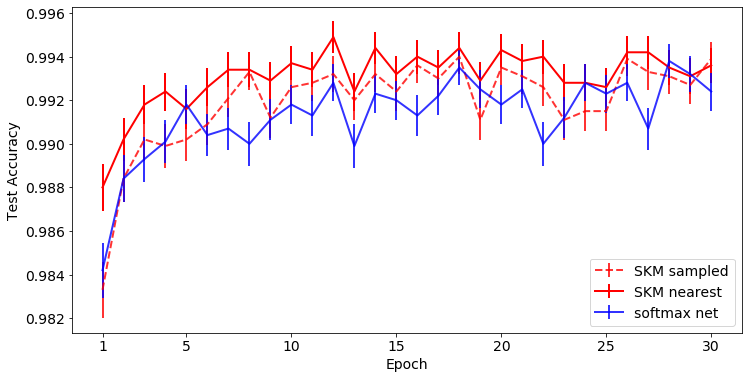

In [15]:
test_stats_df = pd.DataFrame({
    "epoch":np.arange(1, n_epochs+1),
    "sampling_accuracy":test_stats[:, 0], 
    "knn_accuracy":test_stats[:, 1], 
    "softmax_accuracy":test_stats[:, 2]
})

plt.errorbar(
    "epoch", 
    "sampling_accuracy",
    np.sqrt(10000*(1-test_stats_df["sampling_accuracy"]))/10000,
    c="red", 
    linestyle="--", 
    alpha=0.8, 
    label="SKM sampled", 
    data=test_stats_df
)
plt.errorbar(
    "epoch", 
    "knn_accuracy",
    np.sqrt(10000*(1-test_stats_df["knn_accuracy"]))/10000,
    c="red", 
    linestyle="-", 
    alpha=1.0, 
    label="SKM nearest", 
    data=test_stats_df
)
#plt.plot("epoch", "knn_accuracy", c="red", linestyle="-", alpha=1.0, label="nearest skm", data=test_stats_df)
plt.errorbar(
    "epoch", 
    "softmax_accuracy",
    np.sqrt(10000*(1-test_stats_df["softmax_accuracy"]))/10000,
    c="blue", 
    linestyle="-", 
    alpha=0.8, 
    label="softmax net", 
    data=test_stats_df
)

plt.legend(loc="best")
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy");

The error rate should be treated as a stochastic number and not as an exact value. As a good general rule of thumb the 1 sigma error on any integer count is simply the square root of the count itself (which is where we are getting the errorbars in the above plot). Although this approximation breaks down for very small counts it is still an excellent approximation in this regime where whe have around 60 misclassified examples.  Thus the 0.002 difference between the SKM error rate and the softmax error rate should be seen as being uncertain at the level of at least around $\sqrt{60}/10000 \approx 0.0008$ for the regular softmax model. Seen in that light the improvement of 0.002 represents just around a 2.5 sigma significance level, which is suggestive but nothing to hang your hat on. 

You might be suspicious of that error calculation. Shouldn't we add the uncertainty in both error rates in quadrature? That would be a good approximtion if the two errors were uncorrelated with each other. But since we are evaluating the models on the very same data and even have gone out of our way to train the models in the same way and with the same architecture the two error rates can hardly be considered to be independent of each other. In fact the correlation between the two may well be high enough that the difference between the two error rates might actually have a smaller effective uncertainty than either one individually but there is no way to know apriori how highly correlated we should treat the two numbers.

The SKM model learns much faster than the softmax network. The SKM model hits 98.7% accuracy after just one training epoch a full percent higher than that of the regular softmax model. At least some of this rapid training in early iterations is due to the fact that even without any training at all the similarity between pairs of digits of the same class is slightly larger than the similarities between different classes. Thus the SKM model always starts from a model which slightly beats random chance predictions whereas the regular softmax network will usually start from a model which is slightly worse than random chance.

Although the sampled SKM model somewhat underperforms relative to the nearest neighbor version at first it eventually comes to very nearly match its performance in later epochs. The nearest neighbor search is actually many times faster to carry out than the sampling estimator and so the nearest neighbor estimator is the clear winner. However the sampling estimator retains value as a diagnostic tool especially since it more closely mimics what the model looks like from the perspective of a single training batch. If the sampling estimator doesn't do a good job that may mean individual training batches don't provide enough information to drive meaningful gradients. 

Ideally it would be nice to see a series of experiments on lots of different data sets and a proper comparison of the performance of the networks when each network has its hyper-parameters set via search to be optimized for their respective models instead of sharing the hyper parameter values as we have done here to avoid hyper parameter searching. I have made some preliminary SKM models on several different more challenging data sets such as fashion MNIST, cifar10, cifar100, and SVHN and may do a comparison post in the future so stay tuned.

# Embedding Dimensionality 

The use of a full 10 dimensions for the SKM embedding is probably sub-obpimal there is no need for all that space for this particular problem. Because the SKM relys on close collisions of prototype examples with the target examples for prediction it helps to keep the dimensionality of the similarity space into which we embed points relatively small. The larger the dimension the less likely two points are to get mapped near to each other. 

During training the advantages of having a lower effective dimension outweigh the potential extra freedom of having more space to map points to and so the model learns to restrict itself to a low dimensional subspace of the embedding. For this data and choice of kernel it seems that the model benefits from having perhaps 6 dimensions and learns to effectively restrict itself onto a 6 dimensional subspace. You may suppose that the apparent reduction in the number of dimensions is a property of the PCA and not a property of the data or the model but I can tell you that even if you use a 20 or 30 dimensional similarity space the model still learns to restrict itself to a subspace of effectively the same dimension with almost no variance at all in the final dozen or more dimensions.

In [16]:
train_embed = feature_nn.predict(x_train)
softmax_probs = softmax_model.predict(x_train)

pca_skm = sklearn.decomposition.PCA().fit(train_embed)
pca_softmax = sklearn.decomposition.PCA().fit(softmax_probs)

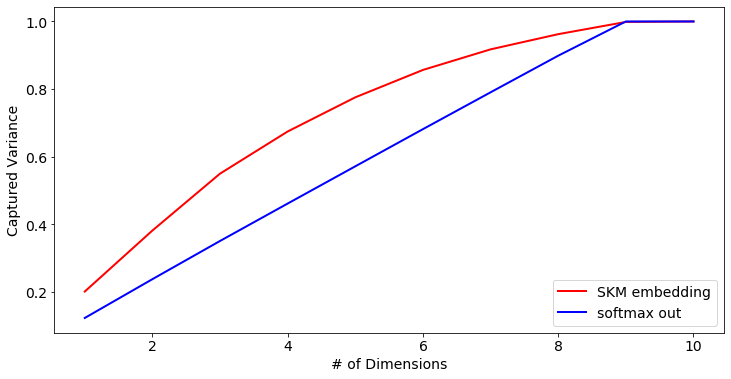

In [17]:
plt.plot(np.arange(1, 11), np.cumsum(pca_skm.explained_variance_ratio_), color="r", label="SKM embedding")
plt.plot(np.arange(1, 11), np.cumsum(pca_softmax.explained_variance_ratio_), color="b", label="softmax out")
plt.legend(loc=4)
plt.xlabel("# of Dimensions")
plt.ylabel("Captured Variance");

# Prediction Confidence

Although the performance difference in the models is small and may even be spurious where the SKM model really shines is in the fact that it comes with a built in confidence mechanism. Ideally our class probabilities would be well calibrated so that an output of probability 0.9 would actually mean that we can expect the predicted class to be right 90% of the time and wrong 10% of the time. Unfortunately coming up with well calibrated probabilities (and being confident that they are in fact well calibrated) is actually a MUCH harder problem than coming up with reasonable probability estimates. 

For example take the classic probability problem of randomly drawing balls out of a bucket (with replacement). If you draw 1 ball out and it is red you might assign a probability of 100% to the next ball being red. If you are a little more reasonable (or are a bayesian instead of a frequentist) you would perhaps hedge your bets a little and apply a weak prior. With a typical bit of baysian logic you might add a "pseudocount" of 1/2 to your observations of red and not-red balls. With those numbers you would come up with a probability estimate (1+1/2)/(1+1/2+1/2) = 0.75 which seems reasonable to me.

If you were offered an even odds bet that the next ball is some other color than red you probably shouldn't take the bet (or at any rate I would not take that bet). Just about any reasonable (weak) prior that you might pick will lead you to an estimate of the probability that is greater than 50%. However, I think it is intuitively clear that the confidence we should assign to the chances that the true probability is greater than 50% should not be high. The very fact that the bet is being offered at all may mean that whoever is offering the bet knows something we don't, and we should be wary.  
Contrast that to the situation where you have drawn 1,000 samples and have drawn 75% reds. Although your probability estimate is the same as before your confidence in that probability is vastly greater and now you can take the bet confidently. The probability of the true red fraction being below 50% in that case is vanishingly small.

To swing back around to the problem of predicting a digit label given an image. Instead of drawing balls from a bucket we are drawing test images from our hold out set and instead of "red" and "not red" we are recording correct and incorrect predictions. If we put all 10,000 of our test images into one "bucket" so to speak then we end up with the global error estimate (and uncertainties in that error) that we used in the test accuracy vs epoch plot above. 

However not all of our predictions are of the same quality and we needn't lump them all together when we figure out how well our model performs. For example if our output probabilities are well calibrated then the predictions of digits with a maximum class probability of 90% will be right 90% of the time and are high quality predictions. On the other hand if the probabilities are more spread out so that the maximum probability of any one class is just 60% that prediction is of a somewhat lower quality.

In the case of our softmax model if a new training sample explores a region of activation space which is extremely different from anything ever seen by the network during training then the resultant prediction is likely to be nonsense. In these edge cases our model may give us a predicted class likelihood for a certain class of 99.999% and still be totally wrong. Because the softmax network retains no information about what "typical" behavior looks like it very happily will return a very confident prediction even for extremely odd examples. 

On the other hand SKM works entirely by making a sort of analogy between the current example and the set of prototype examples available to it. Thus if the SKM model encounters a sample which explores a completely new region of activation space never before seen it will be far from all known examples and get a very low total similarity sum. The similarity sum is a sort of estimate of the density of training prototypes in the space near the target image to be predicted. If the density of prototypes near an image is low then that image represents something new and unusal and we should be suspicious of any predictions we make. On the other hand if there are lots of nearby example prototypes then we are on well trodden metaphorical ground and the predictions of the SKM model should be of high quality.

Lets see how well the probability of the softmax model and/or the neighbor count of the SKM model predicts the quality of our answers and compare the two.

In [18]:
test_pseudocounts_knn = knn_skm_predictor(
    embedding_model=feature_nn,
    prototype_data=x_train,
    prototype_labels=y_train_onehot,
    target_data=x_test,
    sim_kernel=sim_kernel_np,
    k_neighbors=21,
    normalize=False
)
test_probs_softmax = softmax_model.predict(x_test)

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


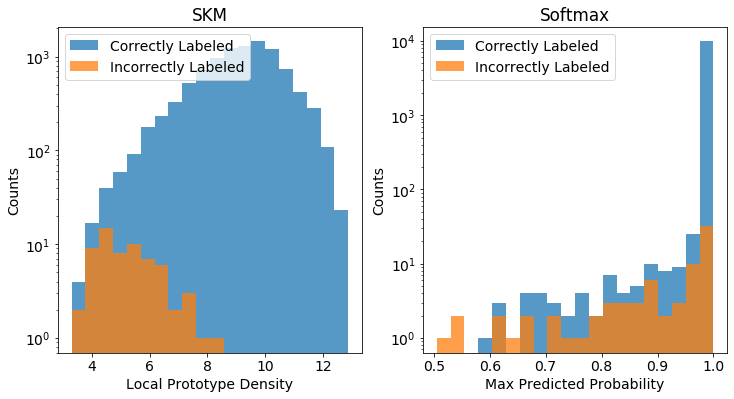

In [19]:
fig, axes = plt.subplots(1, 2)

confidences = [
    np.sum(test_pseudocounts_knn, axis=1),
    np.max(test_probs_softmax, axis=1)
]
prob_sets = [test_pseudocounts_knn, test_probs_softmax]

for i in range(2):
    cprob = prob_sets[i]
    is_correct = y_test == np.argmax(cprob, axis=1)
    cconf = confidences[i]
    
    min_conf = np.min(cconf)
    max_conf = np.max(cconf)
    bins = np.linspace(min_conf, max_conf, 21)#(cconf-min_conf)/(max_conf-min_conf)
    #bins = np.linspace(0, 1, 21)
    
    axes[i].hist(cconf[is_correct], bins, alpha=0.75, normed=False, log=True, label="Correctly Labeled")
    axes[i].hist(cconf[np.logical_not(is_correct)], bins, alpha=0.75, normed=False, log=True, label="Incorrectly Labeled")
    
for ax in axes:
    ax.set_ylabel("Counts")

axes[0].set_xlabel("Local Prototype Density")
axes[1].set_xlabel("Max Predicted Probability")
axes[0].set_title("SKM")
axes[1].set_title("Softmax");
axes[0].legend()
axes[1].legend();

Although both the softmax model and SKM model get more than 99% of the digit labels right the softmax model gives very little indication of when its answers might possibly be wrong. Just about 50% of all of the 80 incorrectly labeled digits get right up to the maximum allowed probability for their (incorrect) predicted label. On the other hand the SKM model only makes incorrect predictions when the digits in question get mapped to very unusual places in the embedding space, as indicated by the relatively low similarities of the nearest points.

Having a good way to know when your model's predictions are likely to be poor is just as valuable as knowing how well your model is likely to perform. Especially in the cases where models are driving decisions it can be incredibly valuable to know whether that 99% class prediction represents a well considered 99% drawing from thousands of training examples or the vacuous sort of 99% class prediction that arose because we have never seen anything like that situation before.

Suppose we feed an image through the softmax classifier and get a maximum predicted label probability of 90%. Further suppose we are offered a bet wherein we will pay out 2 dollars if the prediction turns out to be incorrect and will be paid 1 dollar if the prediction is incorrect. You may naively assume that the expectation of that bet is 70 cents. Since the softmax model is right 99.2 percent of the time it must be pretty good and if we trust its prediction of a 90% chance of winning a dollar and a ten percent chance of losing 2 dollars we come out with a 70 cent gain on average.

But if we look at the plot above in the few cases where no one class got more than a 90% predicted probability we see a very different story. The softmax model is almost always essentially 100% certain of every category and in the very few cases where the model doesn't come out with a probability of 99.9% for just one particular label then the numbers of correctly and incorrectly classified digit examples is actually roughly half and half. So the information that our model was only 90% certain actually means that we should expect to lose 2 dollars half the time and win 1 dollar half the time making the expectation of that bet about negative one dollars. In fact because the most common probability assigned to incorrect predictions by the softmax model is near 100% there are not really any predictions we can be more confident of than the general prediction. 

On the other hand if we consider the density of prototype data via the SKM model we can clearly see that if we are granted the information that a test image has a prototype density at least as high as the average density then the error rate is so low that the 10,000 held out test images is just not enough to estimate it. That is pretty cool.

# Embedding Space Visualization

Lets plot up 2 of the 10 dimensions of the embedding space and see how the densities of different digits lay out.

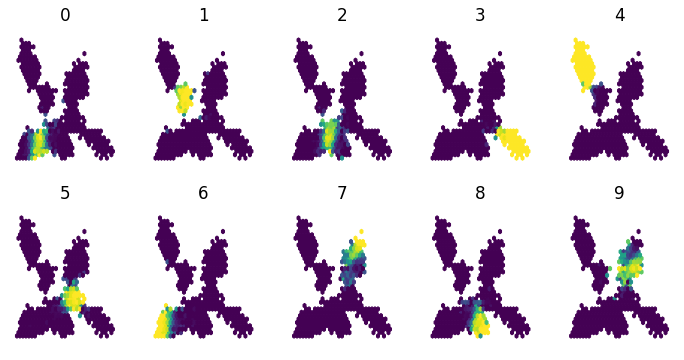

In [20]:
train_embed = feature_nn.predict(x_train)
test_embed = feature_nn.predict(x_test)

test_embed_pct = pca_skm.transform(test_embed)

fig, axes = plt.subplots(2, 5)
axes = axes.ravel()

for i in range(10):
    axes[i].axis("off")
    axes[i].set_title("{}".format(i))
    axes[i].hexbin(
        test_embed_pct[:, 0], 
        test_embed_pct[:, 1], 
        C=y_test_onehot[:, i],
        mincnt=3,
        gridsize=35,
    )

# Image Distance Distributions

Finally because the whole SKM classification process depends on inter image distances lets plot up some distance and similarity matrices and see how the two tend to interact.

In [21]:
dist_mat = scipy.spatial.distance_matrix(test_embed[:1000], train_embed[:1000])
sim_matrix = sim_kernel_np(dist_mat)

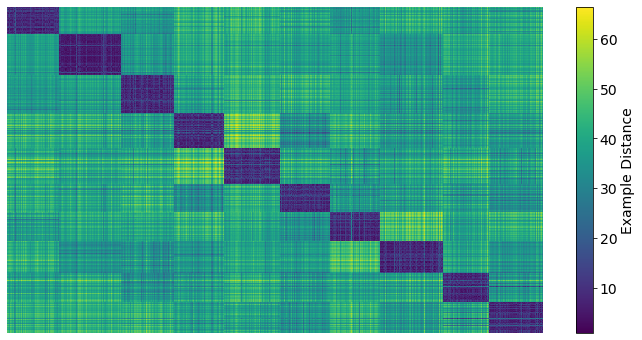

In [22]:
fig, ax = plt.subplots()
ax.axis("off")

si_row = np.argsort(y_test[:len(dist_mat)])
si_col = np.argsort(y_train[:dist_mat.shape[1]])
plt.imshow(dist_mat[si_row][:, si_col])
cbar = plt.colorbar().set_label("Example Distance")
plt.xlabel("Prototype Images")
plt.ylabel("Test Images");

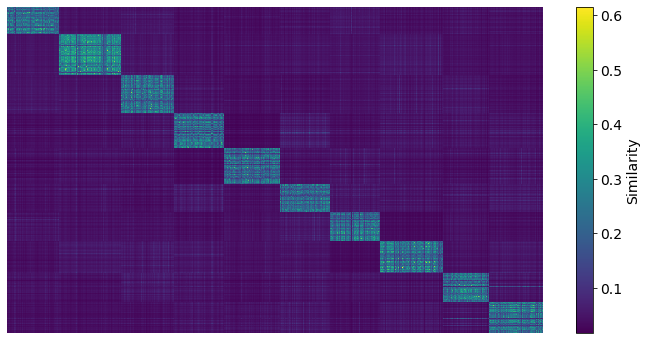

In [23]:
fig, ax = plt.subplots()
ax.axis("off")

si_row = np.argsort(y_test[:len(dist_mat)])
si_col = np.argsort(y_train[:dist_mat.shape[1]])
plt.imshow(sim_matrix[si_row][:, si_col])
plt.colorbar().set_label("Similarity")
plt.xlabel("Prototype Images")
plt.ylabel("Test Images");

In [24]:
same_to_same = np.zeros(dist_mat.shape, dtype=bool)
for i in range(10):
    cmask_row = y_test[:dist_mat.shape[0]] == i
    cmask_col = y_train[:dist_mat.shape[1]] == i
    same_to_same += np.dot(cmask_row.reshape((-1, 1)), cmask_col.reshape((1, -1)))

same_to_diff = np.logical_not(same_to_same)

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


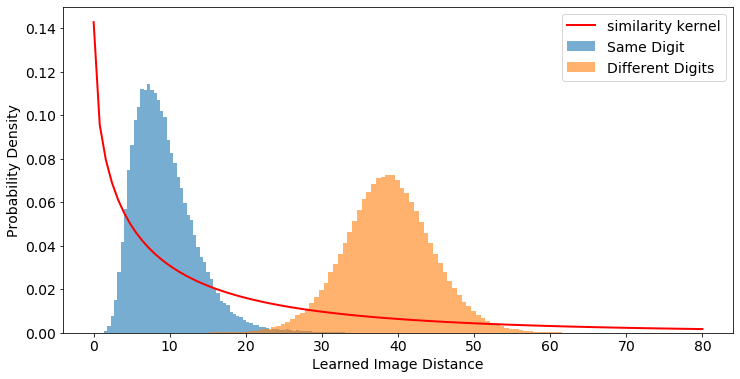

In [25]:
plt.hist(dist_mat[same_to_same], 101, alpha=0.6, normed=True, label="Same Digit");
plt.hist(dist_mat[same_to_diff], 101, alpha=0.6, normed=True, label="Different Digits");
r = np.linspace(0, 80, 101)
plt.plot(r, 0.15*sim_kernel_np(r), c="r", label="similarity kernel")
plt.xlabel("Learned Image Distance")
plt.ylabel("Probability Density")
plt.legend();

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


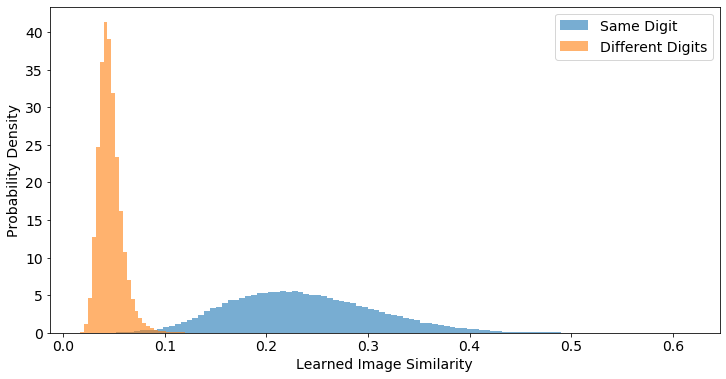

In [26]:
plt.hist(sim_matrix[same_to_same], 101, alpha=0.6, normed=True, label="Same Digit");
plt.hist(sim_matrix[same_to_diff], 101, alpha=0.6, normed=True, label="Different Digits");
plt.xlabel("Learned Image Similarity")
plt.ylabel("Probability Density")
plt.legend();

It is clear to see that the learned embedding has indeed managed to locate images belonging to the same digit much more closely together than those belonging to different digits. From the perspective of maximizing the probability of the target class it would be ideal to have the similarity of all non-similar digits be exactly 0. However due to our slowly decaying exponential kernel nearly all images have a non-zero similarity to each other. For the reasons that we discussed in the kernel section above this actually leads to more robust training of the model. Though what the choice of optimal kernel might be is very much an open question both in terms of functional form and/or any associated hyper parameters.